In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import palettable
colors = palettable.colorbrewer.qualitative.Set2_7.mpl_colors

In [3]:
!scp bullx:/scratch/sebastian.horl/boptx/examples/eqasim/calibration_daily_flow.p .

calibration_daily_flow.p                      100% 6279KB  28.1MB/s   00:00    


In [4]:
with open("calibration_daily_flow.p", "rb") as f:
    data = pickle.load(f)

In [5]:
indices = [
    i for i in  np.arange(len(data["evaluations"]))
    if not data["evaluations"][i]["transitional"]
]

objectives = np.array([
    evaluation["objective"] for evaluation in data["evaluations"] if not evaluation["transitional"]
])

evaluations = np.arange(len(objectives))
    
values = np.array([
    evaluation["values"] for evaluation in data["evaluations"] if not evaluation["transitional"]
])

stuck_objectives = np.array([
    evaluation["information"]["matsim"]["components"]["stuck"]["objective"]
    for evaluation in data["evaluations"] if not evaluation["transitional"]
])

flow_objectives = 0.1 * np.array([
    evaluation["information"]["matsim"]["components"]["flow"]["objective"]
    for evaluation in data["evaluations"] if not evaluation["transitional"]
])

In [6]:
iterations = np.array([
    evaluation["information"]["matsim"]["iterations"]["current"]
    for evaluation in data["evaluations"] if not evaluation["transitional"]
])

Text(0, 0.5, 'MATSim Iterations')

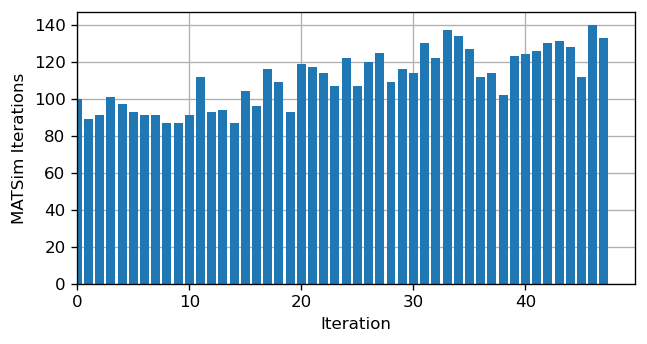

In [7]:
plt.figure(dpi = 120, figsize = (6, 3))
plt.bar(np.arange(len(iterations)), iterations, zorder = 2)

plt.grid(zorder = 0)
plt.xlim([0, None])
plt.ylim([0, None])

plt.xlabel("Iteration")
plt.ylabel("MATSim Iterations")

In [8]:
best_indices = [0]

for index in range(1, len(objectives)):
    if objectives[index] < objectives[best_indices[-1]]:
        best_indices.append(index)
    else:
        best_indices.append(best_indices[-1])
        
best_objectives = [objectives[i] for i in best_indices]

Text(0, 0.5, 'Objective')

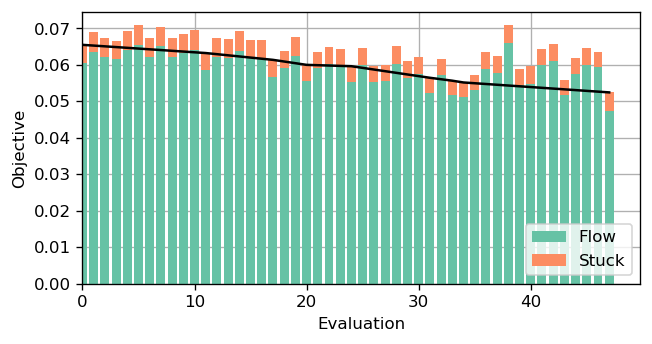

In [9]:
plt.figure(dpi = 120, figsize = (6, 3))

lower = np.zeros((len(evaluations),))

plt.bar(evaluations, lower + flow_objectives, bottom = lower, color = colors[0], 
                 label = "Flow", zorder = 2, linewidth = 0.0)
lower += flow_objectives

plt.bar(evaluations, stuck_objectives, bottom = lower, color = colors[1], 
                 label = "Stuck", zorder = 2, linewidth = 0.0)

unique_indices = np.unique(best_indices, return_index = True)[1]
plt.plot(evaluations[unique_indices], objectives[unique_indices], "k")

plt.legend(loc = "best")
plt.grid(zorder = 0)
plt.xlim([0, None])
plt.ylim([0, None])

plt.xlabel("Evaluation")
plt.ylabel("Objective")

In [10]:
df_osm = pd.read_csv("/home/shoerl/explo22/data/network_matching.csv", sep = ";")[["simulation_id", "osm"]]
df_osm = df_osm.rename(columns = { "simulation_id": "link_id" })

In [13]:
plt.figure(figsize = (8, 4), dpi = 120)
index = indices[best_indices[-1]]
#index = 0

df = data["evaluations"][index]["information"]["matsim"]["components"]["flow"]["configuration"]["data"]
df = pd.merge(df, df_osm, on = "link_id")

df["category"] = "minor"

f = df["osm"].str.startswith("motorway") | df["osm"].str.startswith("trunk") 
df.loc[f, "category"] = "major"

f = df["osm"].str.startswith("primary") | df["osm"].str.startswith("secondary") 
df.loc[f, "category"] = "intermediate"

f = df["osm"].str.contains("link")
df.loc[f, "category"] = "link"

import palettable
colors = palettable.colorbrewer.qualitative.Set2_7.mpl_colors

for category_index, category in enumerate(["major", "intermediate", "minor", "link"]):
    f = df["category"] == category
    
    plt.plot(
        df[f & ~df["valid"]]["reference_flow"], df[f & ~df["valid"]]["scaled_flow"], ".", 
        color = colors[category_index], alpha = 0.25)
    
    plt.plot(
        df[f & df["valid"]]["reference_flow"], df[f & df["valid"]]["scaled_flow"], ".", 
        color = colors[category_index], label = category)

plt.plot([0, df["reference_flow"].max()], [0, df["reference_flow"].max()], "k--")
    
plt.legend(loc = "best", ncol = 2)
plt.grid()
plt.xlabel("Reference flow")
plt.xlabel("Simulation flow")

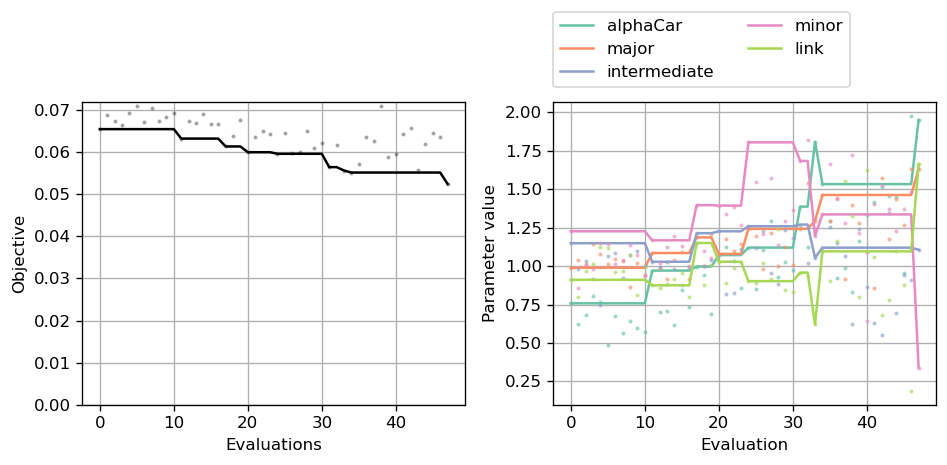

In [12]:
plt.figure(figsize = (8, 4), dpi = 120)

plt.subplot(1, 2, 1)
plt.plot(evaluations, objectives, "k.", alpha = 0.25, markersize = 3)
plt.plot(evaluations, best_objectives, "k")
plt.ylim([0, None])
plt.xlabel("Evaluations")
plt.ylabel("Objective")
plt.grid()

plt.subplot(1, 2, 2)

best_values = np.array([
    values[i] for i in best_indices
])

import palettable
colors = palettable.colorbrewer.qualitative.Set2_7.mpl_colors
#colors = palettable.cubehelix.Cubehelix.make(start=0.3, rotation=-0.5, n=16).mpl_colors

labels = [
    "alphaCar", "major", "intermediate", "minor", "link"
]

for k in range(values.shape[1]):
    plt.plot(values[:,k], ".", color = colors[k], alpha = 0.5, markersize = 3)
    plt.plot(best_values[:,k], color = colors[k], label = labels[k])
    
plt.grid()
plt.xlabel("Evaluation")
plt.ylabel("Parameter value")
plt.legend(loc = (0,1.05), ncol = 2)

#plt.ylim([-2.0, 2.0])

plt.tight_layout()